In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import MicroTools as micro
from MicroTools import plot_tools as pt
import MiniTools as mini
import param_scan

from importlib.resources import open_text


In [4]:
# settings for Fig. 1
TOTAL_RATE = False
INCLUDE_MB_LAST_BIN = False
STACKED = False
PLOT_FAMILY=False
colormap=cm.Blues
TEMP1_COLOR = 'deeppink'
TEMP2_COLOR = 'dodgerblue'

PATH_PLOTS = 'plots/event_rates/'

In [44]:
params = {'g': 1e-3, 'Ue4Sq': 0.1, 'Um4Sq': 3e-2/4, 'm4': 1}

rates_dic_osc = param_scan.get_nue_rates(params, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=False, energy_degradation=False, n_replications=1, undo_numu_normalization=False)
rates_dic_decay = param_scan.get_nue_rates(params, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=False, energy_degradation=False, n_replications=10, undo_numu_normalization=False)

In [45]:
Weight_nue_flux = mini.apps.reweight_MC_to_nue_flux(
            param_scan.Etrue_nue, param_scan.Weight_nue, mode="fhc"
        )

MC_nue_bkg_intrinsic = np.dot(
                param_scan.fast_histogram(
                    param_scan.Etrue_nue, bins=param_scan.e_prod_e_int_bins, weights=Weight_nue_flux
                )[0],
                mini.apps.migration_matrix_official_bins_nue_11bins,
            )

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_2822/3661257215.py:16: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_2822/3661257215.py:22: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(


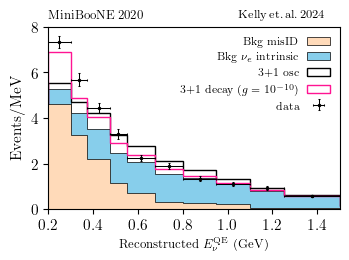

In [89]:
fig, ax1 = pt.std_fig(figsize=(3*1.2,2*1.2))
bins = param_scan.MB_Ereco_official_bins
bin_w = np.diff(bins)
bin_c = bins[:-1] + bin_w/2

######################################
# MiniBooNE 
if TOTAL_RATE:
    units= 1
    ax1.set_ylabel(r"Events")
else:
    units = 1/micro.bin_width
    ax1.set_ylabel(r"Events/MeV")

nue_data = np.genfromtxt(
    open_text(
        f"MiniTools.include.MB_data_release_2020.combined",
        f"miniboone_nuedata_lowe.txt",
    )
)
nue_bkg = np.genfromtxt(
            open_text(
                f"MiniTools.include.MB_data_release_2020.combined",
                f"miniboone_nuebgr_lowe.txt",
            )
        )
nue_bkg_midID = nue_bkg - MC_nue_bkg_intrinsic

# plot data
pt.data_plot(ax1, 
          X=bin_c,
          Y=nue_data*units, 
          xerr=bin_w/2, 
          yerr=np.sqrt(nue_data)*units,
          zorder=3)


ax1.hist(bins[:-1],
        bins=bins,
        weights=(nue_bkg_midID)*units,
        edgecolor='black',
        facecolor='peachpuff',
        lw=0.5,
        label=r'Bkg misID',
        histtype='stepfilled',
        zorder=2)
ax1.hist(bins[:-1],
        bins=bins,
        # weights=(nue_bkg_midID)*units,
        weights=(nue_bkg)*units,
        edgecolor='black',
        facecolor='skyblue',
        lw=0.5,
        label=r'Bkg $\nu_e$ intrinsic',
        histtype='stepfilled',
        zorder=1.5)


# plot sterile
ax1.hist(bins[:-1],
        bins=bins,
                # weights=(rates_dic_osc['MC_nue_app'] + rates_dic_osc['MC_nue_bkg_total_w_dis'])*units,
                weights=(rates_dic_osc['MC_nue_app'] + nue_bkg)*units,
        edgecolor='black',
        facecolor='None',
        lw=1.0,
        linestyle=(1,(3,0)),
        label=r'3+1 osc',
        histtype='stepfilled',
        zorder=1.5)
ax1.hist(bins[:-1],
        bins=bins,
                # weights=(rates_dic_decay['MC_nue_app'] + rates_dic_decay['MC_nue_bkg_total_w_dis'])*units,
                weights=(rates_dic_decay['MC_nue_app'] + nue_bkg)*units,
        edgecolor='deeppink',
        facecolor='None',
        lw=1.0,
        linestyle=(1,(3,0)),
        label=r'3+1 decay ($g=10^{-10})$',
        histtype='stepfilled',
        zorder=1.5)



ax1.legend(fontsize=8, markerfirst=False, ncol=1)
ax1.annotate(text=r'MiniBooNE 2020', xy=(0.0,1.05), xycoords='axes fraction', fontsize=9)
ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
if INCLUDE_MB_LAST_BIN:
    ax1.set_xticks([0.2,0.5,1,1.5,2,2.5,3])
    ax1.set_xlim(0.2,3)
else:
    ax1.set_xticks([0.2,0.4,0.6,0.8,1,1.2,1.4])
    ax1.set_xlim(0.2,1.5)
ax1.set_ylim(0,8)
# ax1.xaxis.set_major_locator(pt.MultipleLocator(0.5))
# ax1.xaxis.set_minor_locator(pt.MultipleLocator(0.1))

ax1.annotate(text=r'Kelly\,et.\,al.\,2024', xy=(0.65,1.05), xycoords='axes fraction', fontsize=8.5)

fig.savefig(f"{PATH_PLOTS}/Fig_1.png", dpi=400, bbox_inches='tight')
fig.savefig(f"{PATH_PLOTS}/Fig_1.pdf", dpi=400, bbox_inches='tight')